# Value estimation

Not being able to access the transition probability poses two challenges for us to find the optimal policy

1. We can no longer apply dynamic programming methods like value iteration and policy iteration since both requires knowing the transition probability $p(s'|s,a)$
2. Knowing value functions $V^*(s)$ is no longer sufficient for us to determine the optimal action, since the $q^*$-function also depends on $p(s'|s,a)$.

$$q^*(s,a) = \sum_{s'} p(s'|s, a) [r+\gamma V^*(s)]$$

One way of coming around this problem is to directly estimate the $V_{\pi}(s)$ and $q_{\pi}(s,a)$ directly through sampling. Since both functions are essentially expectations, recall that we can estimate expectations through 

$$\mathbb{E}[X] \approx \frac{1}{n}\sum_{i=1}^n X_i$$

Where $X_i$ are samples from the distribution for $X$. This suggests that we can estimate the value function by sampling from trajectories starting with $s_0=s$ and then compute the culmulative reward.

## First-visit v.s. every visit Monte Carlo

We can implement the Monte Carlo method in two different ways. In the first-visit Monte Carlo, we estimate the value function as the  

## BlackJack

In [2]:
!pip -q install gym

import numpy as np
import matplotlib.pyplot as plt
import gym
import itertools
from MonteCarlo import *
import seaborn as sns

env = gym.make('Blackjack-v1', natural=False, sab=False)

## Estimating of value functions

In [3]:
player_sum_range = range(32)       
dealer_card_range = range(1, 11)   
usable_ace_range = [True, False]

states = list(itertools.product(player_sum_range, dealer_card_range, usable_ace_range))
actions = [0, 1]
print(f"Number of available states: {len(states)}")
print(f"Number of available actions: {len(actions)}")

Number of available states: 640
Number of available actions: 2


In [4]:
class MonteCarloValue:
    """
    Monte Carlo method for estimating the value function
    """
    def __init__(self, states, policy):
        """ 
        @param states: list
            A list of available states
        @param policy: Policy
            A Policy instance with sample implemented
        """
        self.states = states
        self.policy = policy
        
    def estimate(self, env, n_episodes, gamma=1.0, every_visit=False):
        """ 
        Estimates the value function
        @param env: any
            The enviroment the agent is interacting with
        @param n_episodes: int
            Number of episodes used
        @param gamma: int
            Discount factor (default=1.0)
        @param every_visit: boolean
            Indicates whether to use every-visit (True) or first-visit (False) Monte Carlo
        
        @return value: dict
            The estimated value fucntion of the form 
            {state1: value1,...}
        """
        value = {state: 0 for state in self.states}
        count = {state: 0 for state in self.states}
        for i in range(n_episodes):
            episode = self.policy.sample(env)
            states = list([state[0] for state in episode.keys()])
            cum_reward = 0
            for t, (state, reward) in enumerate(list(episode.items())[::-1]):
                state = state[0]
                t = len(episode) - t - 1
                cum_reward = gamma * cum_reward + reward
                if every_visit or state not in states[:t]:
                    count[state] += 1
                    value[state] = value[state] + (cum_reward - value[state]) / count[state]
        return value

In [5]:
class stick_at_20_or_21(Policy):
    """
    Implementation of a simple Blackjack policy 
    We stick at 20 or 21 else hit.
    """
    def policy(self, state):
        if state[0] < 20:
            return 1
        return 0

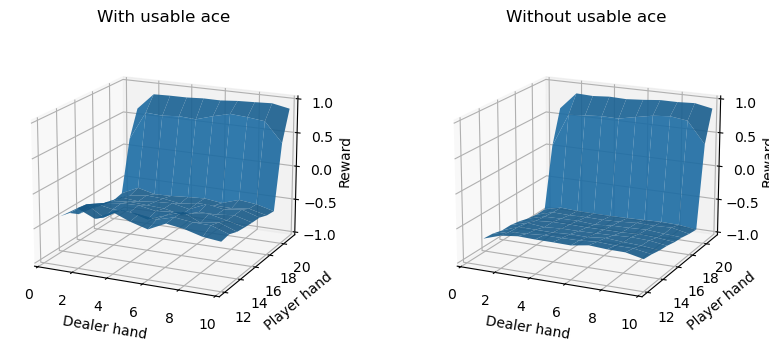

In [6]:
policy = stick_at_20_or_21(states, actions)
mc = MonteCarloValue(states, policy)
values = mc.estimate(env, n_episodes=500000, every_visit=True)
plot_values(values)

## Estimating of q-value function

In [7]:
class MonteCarloQValue:
    """
    Monte Carlo method for estimating the state value function
    """
    def __init__(self, states, actions, policy):
        """ 
        @param states: list
            A list of available states
        @param actions: list
            A list of available actions
        @param policy: Policy
            A Policy instance with sample implemented
        """
        self.states = states
        self.actions = actions
        self.policy = policy
        
    def estimate(self, env, max_iter, gamma=1.0, every_visit=False):
        """ 
        Estimates the value function
        @param env: any
            The enviroment the agent is interacting with
        @param n_episodes: int
            Number of episodes used
        @param gamma: int
            Discount factor (default=1.0)
        @param every_visit: boolean
            Indicates whether to use every-visit (True) or first-visit (False) Monte Carlo
        
        @return value: dict
            The estimated state action fucntion of the form 
            {state1: {action1: q11, action2: q12,...},
             state2: {action1: q21, action2: q22,...},...}
        """
        value = {state: {action: 0 for action in self.actions} for state in self.states}
        count = {state: {action: 0 for action in self.actions} for state in self.states}
        for i in range(max_iter):
            episode = self.policy.sample(env)
            cum_reward = 0
            for t, (state_action, reward) in enumerate(list(episode.items())[::-1]):
                state, action = state_action
                t = len(episode) - t - 1
                cum_reward = gamma * cum_reward + reward
                if every_visit or state not in self.states[:t]:
                    count[state][action] += 1
                    value[state][action] = value[state][action] + (cum_reward - value[state][action]) / count[state][action] 
        return value

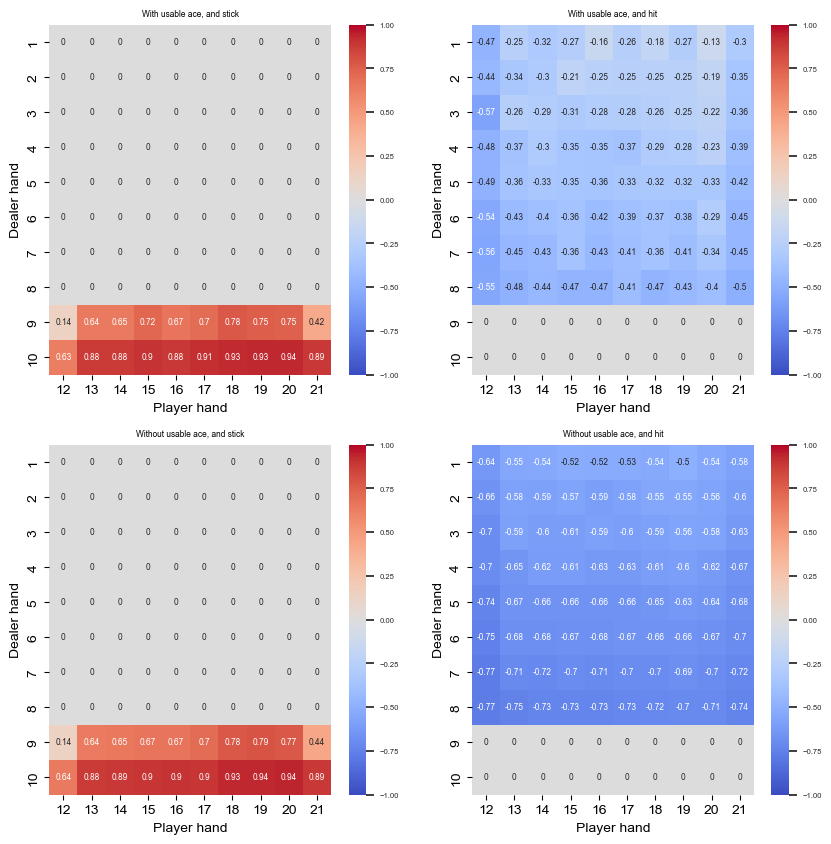

In [8]:
policy = stick_at_20_or_21(states, actions)
montecarlo = MonteCarloQValue(states, actions, policy)
q_values = montecarlo.estimate(env, 500000, every_visit=True)
plot_q_values_heatmap(q_values)